In [1399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix 
import seaborn as sns

### Merge the match data from one year

In [1369]:
frames = []

# Add games from years 2000-2020
for year in range(2000, 2021):
    frames.append(pd.read_csv(f"./data/matches_{year}.csv"))

df = pd.concat(frames)

### Clean up the data

In [1370]:
## irrelevant columns
irr_cols = []
player_cols = ["ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms", "bpSaved", "bpFaced"]
general_cols = ["winner_name", "tourney_name", "loser_name", "winner_ioc", "loser_ioc", "minutes", "score", "draw_size", "round", "loser_seed", "loser_entry", "loser_rank_points", "winner_rank_points", "winner_seed", "winner_entry", "match_num", "tourney_id", "tourney_level", "best_of"]
## add winner/loser cols
for el in player_cols:
    irr_cols.append(f"w_{el}")
    irr_cols.append(f"l_{el}")

## add the general cols
irr_cols.extend(general_cols)

## drop irrelevant cols
df.drop(columns=irr_cols, inplace=True)

## calculate mean height of the players and replace null values with it
mean_ht = (df["winner_ht"].mean() + df["loser_ht"].mean()) / 2
df.loc[df["winner_ht"].isnull(), "winner_ht"] = mean_ht
df.loc[df["loser_ht"].isnull(), "loser_ht"] = mean_ht

## drop empty values
df.dropna(axis=0, inplace=True)

### Convert numerical values to floats

In [1371]:
numeric_cols = ["winner_rank", "loser_rank", "winner_age", "loser_age", "winner_ht", "loser_ht"]
df[numeric_cols] = df[numeric_cols].astype(float)

### Adjust the dataset for performing predictions

In [1372]:
## replace winner/loser with player1 & 2
for (colName, colData) in df.iteritems():
    if "winner" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: f"player1_{endingVal}"}, inplace=True)
    elif "loser" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: f"player2_{endingVal}"}, inplace=True)

first_half, second_half = df[:int(len(df) / 2)], df[int(len(df) / 2):]
first_half.insert(loc=0, column="label", value=1)

## swap columns
scols = list(second_half.columns)

np.warnings.filterwarnings('ignore')

## swap the columns for the second half
for attr in ["id", "hand", "ht", "age", "rank"]:
    scols[scols.index(f"player1_{attr}")], scols[scols.index(f"player2_{attr}")] = scols[scols.index(f"player2_{attr}")], scols[scols.index(f"player1_{attr}")]
    # second_half.insert(loc=0, column="label", value=0)
    second_half["label"] = 0

halves = []

df = pd.concat([first_half, second_half])
df.sample(5)

,label,surface,tourney_date,player1_id,player1_hand,player1_ht,player1_age,player2_id,player2_hand,player2_ht,player2_age,player1_rank,player2_rank
9626,0,Clay,20110110,105559,L,180.000000,20.624230,106121,R,191.000000,17.952088,313.0,976.0
1853,1,Clay,20040809,104745,L,185.000000,18.184805,102644,L,183.000000,28.966461,71.0,154.0
18681,1,Hard,20011008,104093,U,184.686559,18.844627,104479,R,184.686559,16.741958,1069.0,1368.0
818,1,Hard,20000214,103454,R,183.000000,20.347707,102477,R,185.000000,25.278576,99.0,126.0
10030,1,Carpet,20100125,104869,R,188.000000,22.956879,105066,L,183.000000,22.067077,269.0,476.0


### Visualize data

In [1373]:
# cols = ["player1_rank", "player2_rank", "player1_age", "player2_age", "player1_ht", "player2_ht"]

# plt.figure(1, figsize=(18, 8))

# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     df[cols[i]].plot(kind="hist", title=cols[i])

# # plt.ylim([0, 10])
# # plt.xlim([0, 10])
# plt.show()

### Logistic Regression

In [1408]:
## convert categorical values (player hand, surface) to numbers
le = LabelEncoder()
df["surface"] = le.fit_transform(df["surface"])
df["player1_hand"] = le.fit_transform(df["player1_hand"])
df["player2_hand"] = le.fit_transform(df["player2_hand"])

features = ["player1_ht", "player2_ht", "player1_age", "player2_age", "player1_rank", "player2_rank", "surface", "player1_hand", "player2_hand"]
X = df[features]
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()

## training the model
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
acc_train = clf.score(X_train, y_train)
accuracy = clf.score(X, y)

## validation
y_pred_val = clf.predict(X_val)
acc_val = clf.score(X_val, y_val)

print(f"training accuracy: {acc_train}")
print(f"validation accuracy: {acc_val}")

training accuracy: 0.6062470593507047
validation accuracy: 0.60628227676521


### Confusion matrix

In [1396]:
conf_mat = confusion_matrix(y, np.concatenate([y_pred_train, y_pred_val]))

## calculate the precision by dividing TP by (TP + FP)
## it denotes the proportion of true positives in total positives
true_pos = conf_mat[1][1]
false_pos = conf_mat[0][1]
precision = true_pos / (true_pos + false_pos)

print(f"precision: {precision}")

precision: 0.4986049466445747


### Visualize

[Text(0, 0.5, 'L'), Text(0, 1.5, 'W')]

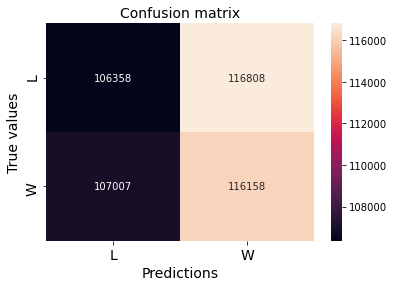

In [1406]:
ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

fontsize = 14

ax.set_title("Confusion matrix", fontsize=fontsize)
ax.set_xlabel("Predictions", fontsize=fontsize)
ax.set_ylabel("True values", fontsize=fontsize)
ax.xaxis.set_ticklabels(["L", "W"], fontsize=fontsize)
ax.yaxis.set_ticklabels(["L", "W"], fontsize=fontsize)